In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
df = pd.read_csv("/workspaces/all_in_one/team1proj/StellarDatasetML/data/stellar_eda.csv")

In [3]:
# recode response variable to 0/1/2
#df = df.replace({"class": {"STAR": 0, "GALAXY": 1, "QSO": 2}})

# Trial 2

In [4]:
target = df['class'].copy()
data = df.drop(columns=['class']).copy()

In [5]:
target.value_counts()

GALAXY    47556
STAR      17274
QSO       15169
Name: class, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

fitting a knn model

In [7]:
def accuracy(y_test, y_preds):
    """Calculates inference accuracy of the model.
    
    Args-
        y_test- Original target labels of the test set
        y_preds- Predicted target lables
    Returns-
        acc
    """
    total_correct = 0
    for i in range(len(y_test)):
        if int(y_test[i]) == int(y_preds[i]):
            total_correct += 1
    acc = total_correct/len(y_test)
    return acc

In [8]:
# Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# create KNN model object
knn = KNeighborsClassifier(n_neighbors=5)

# define loss function
loss = 'accuracy'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(knn, X_train_std, y_train, cv=kfold, scoring=loss)


np.round(results, 3)

array([0.904, 0.906, 0.906, 0.903, 0.904])

## Tuning

In [9]:
# create KNN model object
knn = KNeighborsClassifier()

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(1, 40, 10)}



In [10]:
# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_std, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

0.9001232205043819

In [11]:
# Best model's k value
optimal_k = results.best_estimator_.get_params().get('n_neighbors')
optimal_k

1

In [12]:
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best_fit = knn_best.fit(X_train_std, y_train)

predictions = knn_best_fit.predict(X_train_std)
cm = confusion_matrix(y_train, predictions)
cm

array([[33200,     0,     0],
       [    0, 10711,     0],
       [    0,     0, 12088]])

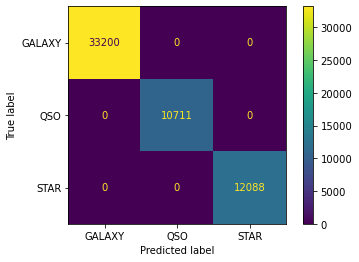

In [13]:
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=knn_best_fit.classes_
  )
  
disp.plot()

In [14]:
knn.fit(X_train, y_train)
print(metrics.classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

      GALAXY       0.74      0.89      0.81     14356
         QSO       0.49      0.40      0.44      4458
        STAR       0.76      0.45      0.57      5186

    accuracy                           0.70     24000
   macro avg       0.66      0.58      0.61     24000
weighted avg       0.70      0.70      0.69     24000



In [ ]:
# r = permutation_importance(
 # knn_best_fit, 
  #X_train_std, 
  ##y_train,
  #n_repeats=2,
  #random_state=0
  #)

In [ ]:
#vip = pd.DataFrame({'feature': X_train.columns.values,
#                    'importance': r.importances_mean})

In [ ]:

                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

In [ ]:
pd_results = partial_dependence(
  knn_best_fit, X_train_std, features=1, kind='average',
  percentiles=(0, 1)) 
  
  
pd_output = pd.DataFrame({'glucose': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('glucose', 'yhat'))
  + geom_line())